In [ ]:
#imports
import os
import torch
import random
import numpy as np
import requests
import matplotlib.pyplot as plt
import sys
import torch.nn as nn
import torch.optim as optim
import copy
import time
from tqdm import tqdm
import gzip
import pickle
import gensim.downloader as gen_api
import gensim.downloader as genapi
from gensim.models import KeyedVectors
import seaborn as sns


seed = 10
random.seed(seed)
np.random.seed(seed)


In [ ]:
# Code for dataset class which is inspired from Dr. Avinash Kak's DL Studio Module with slight modifications.
class SentimentAnalysisDataset(torch.utils.data.Dataset):
    def __init__(self, root, dataset_file, mode = 'train', path_to_saved_embeddings=None):
        super(SentimentAnalysisDataset, self).__init__()
        self.path_to_saved_embeddings = path_to_saved_embeddings
        self.mode = mode
        root_dir = root
        f = gzip.open(root_dir + dataset_file, 'rb')
        dataset = f.read()
        if path_to_saved_embeddings is not None:
            if os.path.exists(path_to_saved_embeddings + 'vectors.kv'):
                self.word_vectors = KeyedVectors.load(path_to_saved_embeddings + 'vectors.kv')
            else:
                self.word_vectors = genapi.load("word2vec-google-news-300")

                self.word_vectors.save(path_to_saved_embeddings + 'vectors.kv')
        if mode == 'train':
            if sys.version_info[0] == 3:
                self.positive_reviews_train, self.negative_reviews_train, self.vocab = pickle.loads(dataset, encoding='latin1')
            else:
                self.positive_reviews_train, self.negative_reviews_train, self.vocab = pickle.loads(dataset)
            self.categories = sorted(list(self.positive_reviews_train.keys()))
            self.category_sizes_train_pos = {category : len(self.positive_reviews_train[category]) for category in self.categories}
            self.category_sizes_train_neg = {category : len(self.negative_reviews_train[category]) for category in self.categories}
            self.indexed_dataset_train = []
            for category in self.positive_reviews_train:
                for review in self.positive_reviews_train[category]:
                    self.indexed_dataset_train.append([review, category, 1])
            for category in self.negative_reviews_train:
                for review in self.negative_reviews_train[category]:
                    self.indexed_dataset_train.append([review, category, 0])
            random.shuffle(self.indexed_dataset_train)
        elif mode == 'test':
            if sys.version_info[0] == 3:
                self.positive_reviews_test, self.negative_reviews_test, self.vocab = pickle.loads(dataset, encoding='latin1')
            else:
                self.positive_reviews_test, self.negative_reviews_test, self.vocab = pickle.loads(dataset)
            self.vocab = sorted(self.vocab)
            self.categories = sorted(list(self.positive_reviews_test.keys()))
            self.category_sizes_test_pos = {category : len(self.positive_reviews_test[category]) for category in self.categories}
            self.category_sizes_test_neg = {category : len(self.negative_reviews_test[category]) for category in self.categories}
            self.indexed_dataset_test = []
            for category in self.positive_reviews_test:
                for review in self.positive_reviews_test[category]:
                    self.indexed_dataset_test.append([review, category, 1])
            for category in self.negative_reviews_test:
                for review in self.negative_reviews_test[category]:
                    self.indexed_dataset_test.append([review, category, 0])
            random.shuffle(self.indexed_dataset_test)

    def review_to_tensor(self, review):
        list_of_embeddings = []
        for i,word in enumerate(review):
            if word in self.word_vectors.key_to_index:
                embedding = self.word_vectors[word]
                list_of_embeddings.append(np.array(embedding))
            else:
                next
        review_tensor = torch.FloatTensor(list_of_embeddings)
        return review_tensor

    def sentiment_to_tensor(self, sentiment):
        sentiment_tensor = torch.zeros(2)
        if sentiment == 1:
            sentiment_tensor[1] = 1
        elif sentiment == 0:
            sentiment_tensor[0] = 1
        sentiment_tensor = sentiment_tensor.type(torch.long)
        return sentiment_tensor

    def __len__(self):
        if self.mode == 'train':
            return len(self.indexed_dataset_train)
        elif self.mode == 'test':
            return len(self.indexed_dataset_test)

    def __getitem__(self, idx):
        sample = self.indexed_dataset_train[idx] if self.mode == 'train' else self.indexed_dataset_test[idx]
        review = sample[0]
        review_category = sample[1]
        review_sentiment = sample[2]
        review_sentiment = self.sentiment_to_tensor(review_sentiment)
        review_tensor = self.review_to_tensor(review)
        category_index = self.categories.index(review_category)
        sample = {'review'       : review_tensor,
                    'category'     : category_index, # should be converted to tensor, but not yet used
                    'sentiment'    : review_sentiment }
        return sample


In [ ]:
# Code for torch.nn GRU with Embeddings inspired from Dr. Avinash Kak's DL Studio Module.
class GRUnetWithEmbeddings(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUnetWithEmbeddings, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[-1]))
        out = self.logsoftmax(out)
        return out, h

    def init_hidden(self):
        weight = next(self.parameters()).data
        #                  num_layers  batch_size    hidden_size
        hidden = weight.new(  2,          1,         self.hidden_size    ).zero_()
        return hidden

In [ ]:
# Code for Bidirectional GRU Network with Embeddings which is inspired from Dr. Avinash Kak's DL Studio Module
# with slight modifications to the Unidirectional GRU
class BiGRUnetWithEmbeddings(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(BiGRUnetWithEmbeddings, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, bidirectional=True)
        self.fc = nn.Linear(2*hidden_size, output_size)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[-1]))
        out = self.logsoftmax(out)
        return out, h

    def init_hidden(self):
        weight = next(self.parameters()).data
        #                  num_layers  batch_size    hidden_size
        hidden = weight.new(  2*2,          1,         self.hidden_size    ).zero_()
        return hidden

In [ ]:
#Code for GRU with embeddings training routine which is inspired from Dr. Avinash Kak's DL Studio Module with slight modifications.
def run_code_for_training_for_text_classification_with_GRU(device, net, dataloader, model_name, epochs, display_interval):
    net = net.to(device)
    criterion = nn.NLLLoss()
    accum_times = []
    optimizer = optim.Adam(net.parameters(), lr=1e-3, betas = (0.5, 0.999))
    training_loss_tally = []
    start_time = time.perf_counter()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader):
            review_tensor,category,sentiment = data['review'], data['category'], data['sentiment']
            review_tensor = review_tensor.to(device)
            sentiment = sentiment.to(device)

            optimizer.zero_grad()
            hidden = net.init_hidden().to(device)
            output, hidden = net(torch.unsqueeze(review_tensor[0], 1), hidden)
            loss = criterion(output, torch.argmax(sentiment, 1))
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

            if (i+1) % display_interval == 0:
                avg_loss = running_loss / float(display_interval)
                training_loss_tally.append(avg_loss)
                current_time = time.perf_counter()
                time_elapsed = current_time-start_time
                print("[epoch:%d  iter:%4d  elapsed_time:%4d secs] loss: %.5f" % (epoch+1,i+1, time_elapsed,avg_loss))
                accum_times.append(current_time-start_time)
                running_loss = 0.0

    torch.save(net.state_dict(), os.path.join('/content/drive/My Drive/saved_models',f'{model_name}.pt'))

    print("Total Training Time: {}".format(str(sum(accum_times))))
    print("\nFinished Training\n\n")
    plt.figure(figsize=(10,5))
    plt.title(f"Training Loss vs. Iterations - {model_name}")
    plt.plot(training_loss_tally)
    plt.xlabel("Iterations")
    plt.ylabel("Training loss")
    plt.legend()
    plt.savefig(f"/content/drive/My Drive/training_loss_{model_name}.png")
    plt.show()

    return training_loss_tally

In [ ]:
#Code for GRU with embeddings testing routine which is inspired from Dr. Avinash Kak's DL Studio Module with slight modifications.
def run_code_for_testing_text_classification_with_GRU(device, net, model_path, dataloader, model_name, display_interval):
    net.load_state_dict(torch.load(model_path))
    net = net.to(device)
    classification_accuracy = 0.0
    negative_total = 0
    positive_total = 0
    confusion_matrix = torch.zeros(2,2)
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            review_tensor,category,sentiment = data['review'], data['category'], data['sentiment']
            review_tensor = review_tensor.to(device)
            sentiment = sentiment.to(device)

            hidden = net.init_hidden().to(device)
            output, hidden = net(torch.unsqueeze(review_tensor[0], 1), hidden)
            predicted_idx = torch.argmax(output).item()
            gt_idx = torch.argmax(sentiment).item()
            if (i+1) % display_interval == 0:
                print("   [i=%d]    predicted_label=%d       gt_label=%d" % (i+1, predicted_idx,gt_idx))
            if predicted_idx == gt_idx:
                classification_accuracy += 1
            if gt_idx == 0:
                negative_total += 1
            elif gt_idx == 1:
                positive_total += 1
            confusion_matrix[gt_idx,predicted_idx] += 1
    print("\nOverall classification accuracy: %0.2f%%" %  (float(classification_accuracy) * 100 /float(i)))
    out_percent = np.zeros((2,2), dtype='float')
    out_percent[0,0] = "%.3f" % (100 * confusion_matrix[0,0] / float(negative_total))
    out_percent[0,1] = "%.3f" % (100 * confusion_matrix[0,1] / float(negative_total))
    out_percent[1,0] = "%.3f" % (100 * confusion_matrix[1,0] / float(positive_total))
    out_percent[1,1] = "%.3f" % (100 * confusion_matrix[1,1] / float(positive_total))
    print("\n\nNumber of positive reviews tested: %d" % positive_total)
    print("\n\nNumber of negative reviews tested: %d" % negative_total)
    print("\n\nDisplaying the confusion matrix:\n")
    out_str = "                      "
    out_str +=  "%18s    %18s" % ('predicted negative', 'predicted positive')
    print(out_str + "\n")
    for i,label in enumerate(['true negative', 'true positive']):
        out_str = "%12s:  " % label
        for j in range(2):
            out_str +=  "%18s%%" % out_percent[i,j]
        print(out_str)

    labels = []
    classes=['negative_reviews', 'positive_reviews']
    num_classes = len(classes)
    for row in range(num_classes):
        rows = []
        total_labels =  np.sum(confusion_matrix.numpy()[row])
        for col in range(num_classes):
            count = confusion_matrix.numpy()[row][col]
            label = str(count)
            rows.append(label)
        labels.append(rows)
    labels = np.asarray(labels)

    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrix.numpy(), annot=labels, fmt="", cmap="Blues", cbar=True,
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f'Confusion Matrix for model {model_name}')
    plt.show()

In [ ]:
# training dataset for sentiment_dataset_train_200
train_dataset_200 = SentimentAnalysisDataset('/content/drive/My Drive/','sentiment_dataset_train_200.tar.gz',
                                         path_to_saved_embeddings = '/content/drive/My Drive/word2vec/')



# testing dataset for sentiment_dataset_train_200
test_dataset_200 = SentimentAnalysisDataset('/content/drive/My Drive/', 'sentiment_dataset_test_200.tar.gz',
                                       mode = 'test', path_to_saved_embeddings = '/content/drive/My Drive/word2vec/')



# Create custom training/testing dataloader for sentiment_dataset_train_200
train_data_loader = torch.utils.data.DataLoader(train_dataset_200, batch_size=1, shuffle=True, num_workers=1)
test_data_loader = torch.utils.data.DataLoader(test_dataset_200, batch_size=1, shuffle=True, num_workers=1)

7499

Device: cuda

The number of learnable parameters in the model: 181402

The number of layers in the model: 10


<ipython-input-3-775f6cc263bc>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  review_tensor = torch.FloatTensor(list_of_embeddings)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[epoch:1  iter: 500  elapsed_time:   6 secs] loss: 0.69508
[epoch:1  iter:1000  elapsed_time:  10 secs] loss: 0.63403
[epoch:1  iter:1500  elapsed_time:  16 secs] loss: 0.65231
[epoch:1  iter:2000  elapsed_time:  20 secs] loss: 0.57855
[epoch:1  iter:2500  elapsed_time:  25 secs] loss: 0.50303
[epoch:1  iter:3000  elapsed_time:  30 secs] loss: 0.42240
[epoch:1  iter:3500  elapsed_time:  34 secs] loss: 0.42395
[epoch:1  iter:4000  elapsed_time:  41 secs] loss: 0.43472
[epoch:1  iter:4500  elapsed_time:  45 secs] loss: 0.40059
[epoch:1  iter:5000  elapsed_time:  49 secs] loss: 0.39574
[epoch:1  iter:5500  elapsed_time:  54 secs] loss: 0.40529
[epoch:1  iter:6000  elapsed_time:  59 secs] loss: 0.41809
[epoch:1  iter:6500  elapsed_time:  63 secs] loss: 0.42388
[epoch:1  iter:7000  elapsed_time:  68 secs] loss: 0.36334


<ipython-input-3-775f6cc263bc>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  review_tensor = torch.FloatTensor(list_of_embeddings)


[epoch:2  iter: 500  elapsed_time:  77 secs] loss: 0.35370
[epoch:2  iter:1000  elapsed_time:  82 secs] loss: 0.36924
[epoch:2  iter:1500  elapsed_time:  87 secs] loss: 0.30264
[epoch:2  iter:2000  elapsed_time:  91 secs] loss: 0.31744
[epoch:2  iter:2500  elapsed_time:  96 secs] loss: 0.34679
[epoch:2  iter:3000  elapsed_time: 100 secs] loss: 0.33386
[epoch:2  iter:3500  elapsed_time: 106 secs] loss: 0.30631
[epoch:2  iter:4000  elapsed_time: 110 secs] loss: 0.28389
[epoch:2  iter:4500  elapsed_time: 115 secs] loss: 0.36915
[epoch:2  iter:5000  elapsed_time: 120 secs] loss: 0.33501
[epoch:2  iter:5500  elapsed_time: 124 secs] loss: 0.29982
[epoch:2  iter:6000  elapsed_time: 128 secs] loss: 0.31290
[epoch:2  iter:6500  elapsed_time: 134 secs] loss: 0.31135
[epoch:2  iter:7000  elapsed_time: 138 secs] loss: 0.33968


<ipython-input-3-775f6cc263bc>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  review_tensor = torch.FloatTensor(list_of_embeddings)


[epoch:3  iter: 500  elapsed_time: 148 secs] loss: 0.26407
[epoch:3  iter:1000  elapsed_time: 152 secs] loss: 0.26455
[epoch:3  iter:1500  elapsed_time: 156 secs] loss: 0.22355
[epoch:3  iter:2000  elapsed_time: 162 secs] loss: 0.23474
[epoch:3  iter:2500  elapsed_time: 166 secs] loss: 0.23873
[epoch:3  iter:3000  elapsed_time: 171 secs] loss: 0.25309
[epoch:3  iter:3500  elapsed_time: 176 secs] loss: 0.27188
[epoch:3  iter:4000  elapsed_time: 180 secs] loss: 0.25837
[epoch:3  iter:4500  elapsed_time: 185 secs] loss: 0.27962
[epoch:3  iter:5000  elapsed_time: 190 secs] loss: 0.24258
[epoch:3  iter:5500  elapsed_time: 194 secs] loss: 0.24272
[epoch:3  iter:6000  elapsed_time: 199 secs] loss: 0.23659
[epoch:3  iter:6500  elapsed_time: 203 secs] loss: 0.27535
[epoch:3  iter:7000  elapsed_time: 208 secs] loss: 0.25925


<ipython-input-3-775f6cc263bc>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  review_tensor = torch.FloatTensor(list_of_embeddings)


[epoch:4  iter: 500  elapsed_time: 218 secs] loss: 0.15975
[epoch:4  iter:1000  elapsed_time: 222 secs] loss: 0.17279
[epoch:4  iter:1500  elapsed_time: 228 secs] loss: 0.18106
[epoch:4  iter:2000  elapsed_time: 232 secs] loss: 0.16688
[epoch:4  iter:2500  elapsed_time: 237 secs] loss: 0.17218
[epoch:4  iter:3000  elapsed_time: 242 secs] loss: 0.13391
[epoch:4  iter:3500  elapsed_time: 246 secs] loss: 0.19215
[epoch:4  iter:4000  elapsed_time: 251 secs] loss: 0.19081
[epoch:4  iter:4500  elapsed_time: 256 secs] loss: 0.15386
[epoch:4  iter:5000  elapsed_time: 260 secs] loss: 0.18719
[epoch:4  iter:5500  elapsed_time: 265 secs] loss: 0.21914
[epoch:4  iter:6000  elapsed_time: 269 secs] loss: 0.17772
[epoch:4  iter:6500  elapsed_time: 274 secs] loss: 0.19837
[epoch:4  iter:7000  elapsed_time: 279 secs] loss: 0.15447


Total Training Time: 8024.368095721013

Finished Training




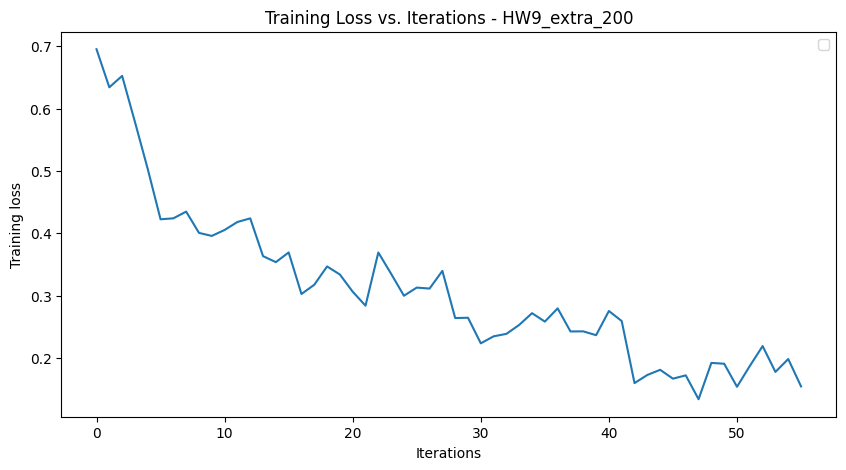

<ipython-input-3-775f6cc263bc>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  review_tensor = torch.FloatTensor(list_of_embeddings)


   [i=500]    predicted_label=0       gt_label=0
   [i=1000]    predicted_label=1       gt_label=1
   [i=1500]    predicted_label=0       gt_label=0

Overall classification accuracy: 86.67%


Number of positive reviews tested: 980


Number of negative reviews tested: 897


Displaying the confusion matrix:

                      predicted negative    predicted positive

true negative:               82.72%             17.28%
true positive:               9.796%            90.204%


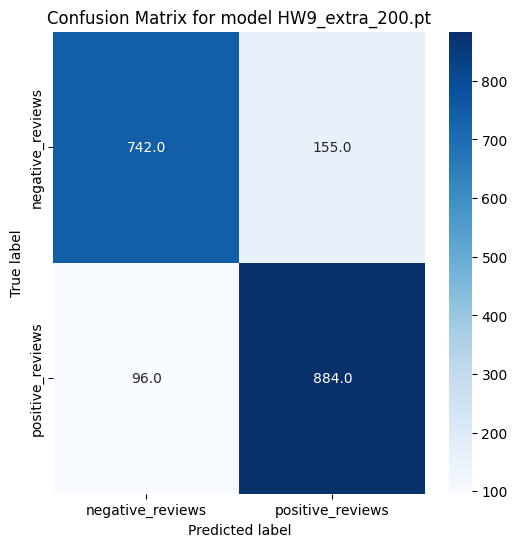

In [ ]:
# Initialize GRU with Embeddings
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {device}")


model = GRUnetWithEmbeddings(input_size=300, hidden_size=100, output_size=2, num_layers=2)

epochs = 4
display_interval = 500

# Count the number of learnable parameters and layers
number_of_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\nThe number of learnable parameters in the model:", number_of_learnable_params)


num_layers = len(list(model.parameters()))
print("\nThe number of layers in the model:", num_layers)

# Training for sentiment_dataset_train_200
net1_losses = run_code_for_training_for_text_classification_with_GRU(device, model, dataloader=train_data_loader,
                                        model_name='HW9_extra_200', epochs=epochs, display_interval=display_interval)

# Testing for sentiment_dataset_train_200
save_path = '/content/drive/My Drive/saved_models/HW9_extra_200.pt'
run_code_for_testing_text_classification_with_GRU(device, model, dataloader=test_data_loader,
                             display_interval=display_interval, model_path=save_path, model_name='HW9_extra_200.pt')


Device: cuda

The number of learnable parameters in the model: 422802

The number of layers in the model: 18


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-3-775f6cc263bc>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  review_tensor = torch.FloatTensor(list_of_embeddings)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[epoch:1  iter: 500  elapsed_time:   6 secs] loss: 0.68949
[epoch:1  iter:1000  elapsed_time:  12 secs] loss: 0.66056
[epoch:1  iter:1500  elapsed_time:  16 secs] loss: 0.60218
[epoch:1  iter:2000  elapsed_time:  21 secs] loss: 0.56123
[epoch:1  iter:2500  elapsed_time:  27 secs] loss: 0.51473
[epoch:1  iter:3000  elapsed_time:  31 secs] loss: 0.43705
[epoch:1  iter:3500  elapsed_time:  36 secs] loss: 0.45928
[epoch:1  iter:4000  elapsed_time:  41 secs] loss: 0.41876
[epoch:1  iter:4500  elapsed_time:  46 secs] loss: 0.44647
[epoch:1  iter:5000  elapsed_time:  52 secs] loss: 0.37988
[epoch:1  iter:5500  elapsed_time:  56 secs] loss: 0.41799
[epoch:1  iter:6000  elapsed_time:  61 secs] loss: 0.43461
[epoch:1  iter:6500  elapsed_time:  67 secs] loss: 0.43056
[epoch:1  iter:7000  elapsed_time:  71 secs] loss: 0.34761


<ipython-input-3-775f6cc263bc>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  review_tensor = torch.FloatTensor(list_of_embeddings)


[epoch:2  iter: 500  elapsed_time:  82 secs] loss: 0.35234
[epoch:2  iter:1000  elapsed_time:  86 secs] loss: 0.35556
[epoch:2  iter:1500  elapsed_time:  92 secs] loss: 0.35857
[epoch:2  iter:2000  elapsed_time:  96 secs] loss: 0.31121
[epoch:2  iter:2500  elapsed_time: 101 secs] loss: 0.30052
[epoch:2  iter:3000  elapsed_time: 107 secs] loss: 0.30844
[epoch:2  iter:3500  elapsed_time: 111 secs] loss: 0.36963
[epoch:2  iter:4000  elapsed_time: 117 secs] loss: 0.35007
[epoch:2  iter:4500  elapsed_time: 121 secs] loss: 0.29257
[epoch:2  iter:5000  elapsed_time: 126 secs] loss: 0.35397
[epoch:2  iter:5500  elapsed_time: 132 secs] loss: 0.26810
[epoch:2  iter:6000  elapsed_time: 136 secs] loss: 0.35704
[epoch:2  iter:6500  elapsed_time: 141 secs] loss: 0.32359
[epoch:2  iter:7000  elapsed_time: 146 secs] loss: 0.31441


<ipython-input-3-775f6cc263bc>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  review_tensor = torch.FloatTensor(list_of_embeddings)


[epoch:3  iter: 500  elapsed_time: 157 secs] loss: 0.25276
[epoch:3  iter:1000  elapsed_time: 161 secs] loss: 0.22978
[epoch:3  iter:1500  elapsed_time: 166 secs] loss: 0.29524
[epoch:3  iter:2000  elapsed_time: 171 secs] loss: 0.22587
[epoch:3  iter:2500  elapsed_time: 176 secs] loss: 0.25006
[epoch:3  iter:3000  elapsed_time: 180 secs] loss: 0.28214
[epoch:3  iter:3500  elapsed_time: 186 secs] loss: 0.24988
[epoch:3  iter:4000  elapsed_time: 191 secs] loss: 0.30046
[epoch:3  iter:4500  elapsed_time: 197 secs] loss: 0.23966
[epoch:3  iter:5000  elapsed_time: 202 secs] loss: 0.24073
[epoch:3  iter:5500  elapsed_time: 206 secs] loss: 0.20531
[epoch:3  iter:6000  elapsed_time: 212 secs] loss: 0.26508
[epoch:3  iter:6500  elapsed_time: 217 secs] loss: 0.22856
[epoch:3  iter:7000  elapsed_time: 222 secs] loss: 0.25046


<ipython-input-3-775f6cc263bc>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  review_tensor = torch.FloatTensor(list_of_embeddings)


[epoch:4  iter: 500  elapsed_time: 232 secs] loss: 0.15213
[epoch:4  iter:1000  elapsed_time: 237 secs] loss: 0.13376
[epoch:4  iter:1500  elapsed_time: 242 secs] loss: 0.17867
[epoch:4  iter:2000  elapsed_time: 246 secs] loss: 0.15878
[epoch:4  iter:2500  elapsed_time: 252 secs] loss: 0.14707
[epoch:4  iter:3000  elapsed_time: 257 secs] loss: 0.14548
[epoch:4  iter:3500  elapsed_time: 262 secs] loss: 0.11184
[epoch:4  iter:4000  elapsed_time: 267 secs] loss: 0.22219
[epoch:4  iter:4500  elapsed_time: 271 secs] loss: 0.14330
[epoch:4  iter:5000  elapsed_time: 277 secs] loss: 0.19391
[epoch:4  iter:5500  elapsed_time: 282 secs] loss: 0.17118
[epoch:4  iter:6000  elapsed_time: 286 secs] loss: 0.18562
[epoch:4  iter:6500  elapsed_time: 292 secs] loss: 0.17869
[epoch:4  iter:7000  elapsed_time: 297 secs] loss: 0.17188


Total Training Time: 8508.789634448016

Finished Training




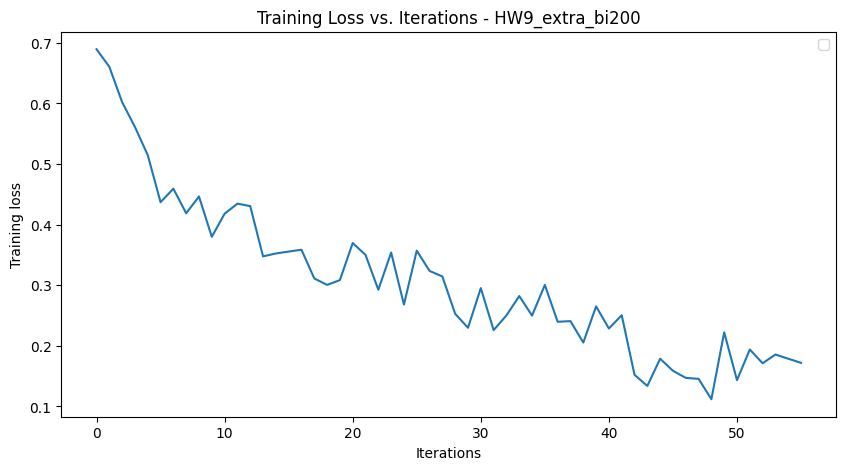

<ipython-input-3-775f6cc263bc>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  review_tensor = torch.FloatTensor(list_of_embeddings)


   [i=500]    predicted_label=1       gt_label=0
   [i=1000]    predicted_label=1       gt_label=1
   [i=1500]    predicted_label=0       gt_label=0

Overall classification accuracy: 86.57%


Number of positive reviews tested: 980


Number of negative reviews tested: 897


Displaying the confusion matrix:

                      predicted negative    predicted positive

true negative:              84.281%            15.719%
true positive:              11.429%            88.571%


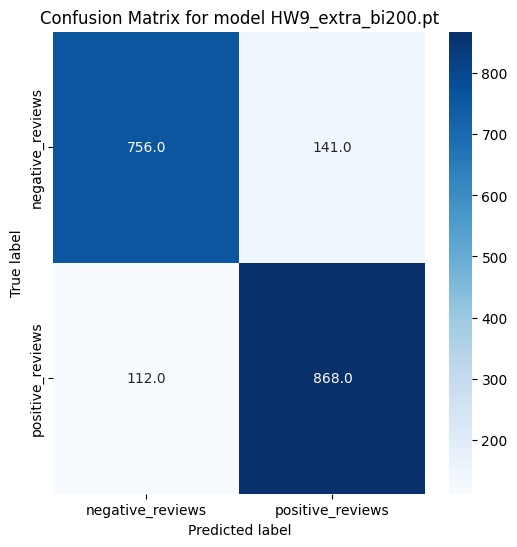

In [ ]:
# Initialize BiGRU with Embeddings
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {device}")

model = BiGRUnetWithEmbeddings(input_size=300, hidden_size=100, output_size=2, num_layers=2)

epochs = 4
display_interval = 500

# Count the number of learnable parameters
number_of_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\nThe number of learnable parameters in the model:", number_of_learnable_params)

# Count the number of layers
num_layers = len(list(model.parameters()))
print("\nThe number of layers in the model:", num_layers)

# Training for sentiment_dataset_train_200
net1_losses = run_code_for_training_for_text_classification_with_GRU(device, model, dataloader=train_data_loader,
                                        model_name='HW9_extra_bi200', epochs=epochs, display_interval=display_interval)

# Testing for sentiment_dataset_train_200
save_path = '/content/drive/My Drive/saved_models/HW9_extra_bi200.pt'
run_code_for_testing_text_classification_with_GRU(device, model, dataloader=test_data_loader,
                             display_interval=display_interval, model_path=save_path, model_name='HW9_extra_bi200.pt')


In [ ]:
# training dataset for sentiment_dataset_train_400
train_dataset_400 = SentimentAnalysisDataset('/content/drive/My Drive/','sentiment_dataset_train_400.tar.gz',
                                         path_to_saved_embeddings = '/content/drive/My Drive/word2vec/')



# testing dataset for sentiment_dataset_train_400
test_dataset_400 = SentimentAnalysisDataset('/content/drive/My Drive/', 'sentiment_dataset_test_400.tar.gz',
                                       mode = 'test', path_to_saved_embeddings = '/content/drive/My Drive/word2vec/')



# Create custom training/validation dataloader
train_data_loader = torch.utils.data.DataLoader(train_dataset_400, batch_size=1, shuffle=True, num_workers=1)
test_data_loader = torch.utils.data.DataLoader(test_dataset_400, batch_size=1, shuffle=True, num_workers=1)

14227

Device: cuda

The number of learnable parameters in the model: 181402

The number of layers in the model: 10


<ipython-input-2-775f6cc263bc>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  review_tensor = torch.FloatTensor(list_of_embeddings)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[epoch:1  iter: 500  elapsed_time:   6 secs] loss: 0.68831
[epoch:1  iter:1000  elapsed_time:  12 secs] loss: 0.64618
[epoch:1  iter:1500  elapsed_time:  16 secs] loss: 0.69067
[epoch:1  iter:2000  elapsed_time:  22 secs] loss: 0.62280
[epoch:1  iter:2500  elapsed_time:  32 secs] loss: 0.58654
[epoch:1  iter:3000  elapsed_time:  39 secs] loss: 0.54959
[epoch:1  iter:3500  elapsed_time:  44 secs] loss: 0.48947
[epoch:1  iter:4000  elapsed_time:  49 secs] loss: 0.49430
[epoch:1  iter:4500  elapsed_time:  54 secs] loss: 0.38483
[epoch:1  iter:5000  elapsed_time:  60 secs] loss: 0.46342
[epoch:1  iter:5500  elapsed_time:  64 secs] loss: 0.37492
[epoch:1  iter:6000  elapsed_time:  68 secs] loss: 0.43083
[epoch:1  iter:6500  elapsed_time:  75 secs] loss: 0.44235
[epoch:1  iter:7000  elapsed_time:  82 secs] loss: 0.42579
[epoch:1  iter:7500  elapsed_time:  88 secs] loss: 0.40255
[epoch:1  iter:8000  elapsed_time:  94 secs] loss: 0.39110
[epoch:1  iter:8500  elapsed_time: 101 secs] loss: 0.372

<ipython-input-2-775f6cc263bc>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  review_tensor = torch.FloatTensor(list_of_embeddings)


[epoch:2  iter: 500  elapsed_time: 169 secs] loss: 0.30596
[epoch:2  iter:1000  elapsed_time: 173 secs] loss: 0.30784
[epoch:2  iter:1500  elapsed_time: 178 secs] loss: 0.35475
[epoch:2  iter:2000  elapsed_time: 183 secs] loss: 0.31557
[epoch:2  iter:2500  elapsed_time: 187 secs] loss: 0.31650
[epoch:2  iter:3000  elapsed_time: 193 secs] loss: 0.34696
[epoch:2  iter:3500  elapsed_time: 197 secs] loss: 0.34552
[epoch:2  iter:4000  elapsed_time: 201 secs] loss: 0.27997
[epoch:2  iter:4500  elapsed_time: 206 secs] loss: 0.33633
[epoch:2  iter:5000  elapsed_time: 210 secs] loss: 0.28792
[epoch:2  iter:5500  elapsed_time: 215 secs] loss: 0.34776
[epoch:2  iter:6000  elapsed_time: 221 secs] loss: 0.32114
[epoch:2  iter:6500  elapsed_time: 225 secs] loss: 0.28927
[epoch:2  iter:7000  elapsed_time: 229 secs] loss: 0.32393
[epoch:2  iter:7500  elapsed_time: 235 secs] loss: 0.30922
[epoch:2  iter:8000  elapsed_time: 240 secs] loss: 0.33142
[epoch:2  iter:8500  elapsed_time: 245 secs] loss: 0.293

Total Training Time: 8932.38095551198

Finished Training




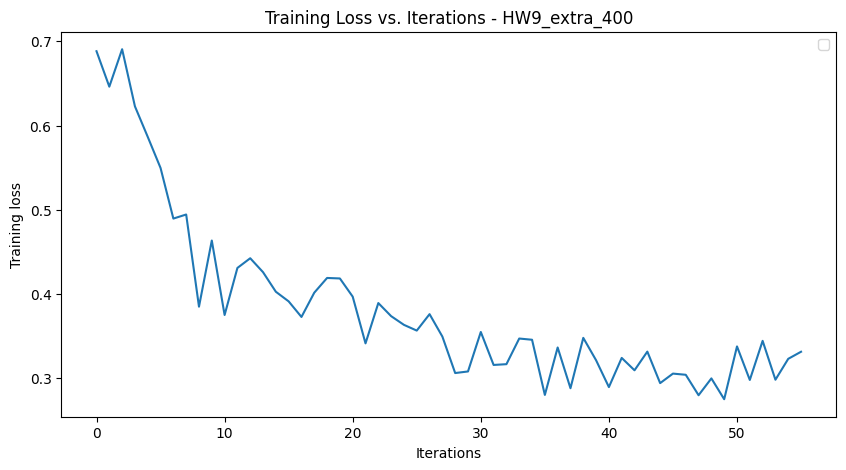

<ipython-input-2-775f6cc263bc>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  review_tensor = torch.FloatTensor(list_of_embeddings)


   [i=500]    predicted_label=1       gt_label=1
   [i=1000]    predicted_label=0       gt_label=0
   [i=1500]    predicted_label=1       gt_label=1
   [i=2000]    predicted_label=0       gt_label=0
   [i=2500]    predicted_label=1       gt_label=1
   [i=3000]    predicted_label=0       gt_label=1
   [i=3500]    predicted_label=1       gt_label=1

Overall classification accuracy: 86.22%


Number of positive reviews tested: 1911


Number of negative reviews tested: 1652


Displaying the confusion matrix:

                      predicted negative    predicted positive

true negative:              89.286%            10.714%
true positive:              16.484%            83.516%


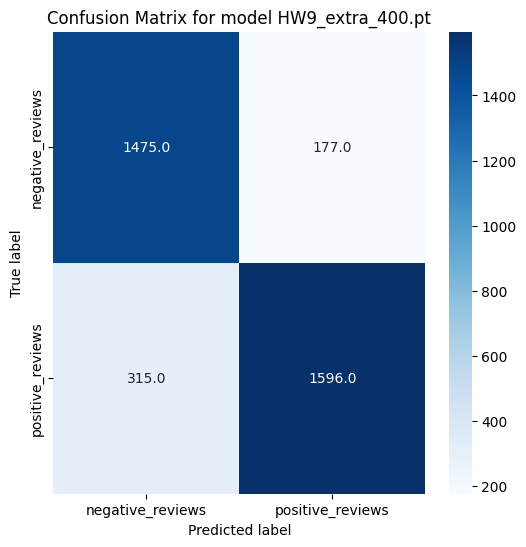

In [ ]:

# Initialize GRU with Embeddings
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {device}")

model = GRUnetWithEmbeddings(input_size=300, hidden_size=100, output_size=2, num_layers=2)


epochs = 2
display_interval = 500

# Count the number of learnable parameters
number_of_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\nThe number of learnable parameters in the model:", number_of_learnable_params)

# Count the number of layers
num_layers = len(list(model.parameters()))
print("\nThe number of layers in the model:", num_layers)

# training for sentiment_dataset_train_400
net1_losses = run_code_for_training_for_text_classification_with_GRU(device, model, dataloader=train_data_loader,
                                        model_name='HW9_extra_400', epochs=epochs, display_interval=display_interval)

# testing for sentiment_dataset_train_400
save_path = '/content/drive/My Drive/saved_models/HW9_extra_400.pt'
run_code_for_testing_text_classification_with_GRU(device, model, dataloader=test_data_loader,
                             display_interval=display_interval, model_path=save_path, model_name='HW9_extra_400.pt')


Device: cuda

The number of learnable parameters in the model: 422802

The number of layers in the model: 18


<ipython-input-2-775f6cc263bc>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  review_tensor = torch.FloatTensor(list_of_embeddings)


[epoch:1  iter: 500  elapsed_time:   7 secs] loss: 0.67416
[epoch:1  iter:1000  elapsed_time:  13 secs] loss: 0.62304
[epoch:1  iter:1500  elapsed_time:  19 secs] loss: 0.63332
[epoch:1  iter:2000  elapsed_time:  24 secs] loss: 0.51179
[epoch:1  iter:2500  elapsed_time:  29 secs] loss: 0.43176
[epoch:1  iter:3000  elapsed_time:  34 secs] loss: 0.43318
[epoch:1  iter:3500  elapsed_time:  39 secs] loss: 0.40417
[epoch:1  iter:4000  elapsed_time:  45 secs] loss: 0.46652
[epoch:1  iter:4500  elapsed_time:  49 secs] loss: 0.39094
[epoch:1  iter:5000  elapsed_time:  54 secs] loss: 0.37844
[epoch:1  iter:5500  elapsed_time:  60 secs] loss: 0.38785
[epoch:1  iter:6000  elapsed_time:  64 secs] loss: 0.37817
[epoch:1  iter:6500  elapsed_time:  72 secs] loss: 0.37580
[epoch:1  iter:7000  elapsed_time:  76 secs] loss: 0.37910
[epoch:1  iter:7500  elapsed_time:  81 secs] loss: 0.39001
[epoch:1  iter:8000  elapsed_time:  86 secs] loss: 0.39941
[epoch:1  iter:8500  elapsed_time:  91 secs] loss: 0.404

<ipython-input-2-775f6cc263bc>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  review_tensor = torch.FloatTensor(list_of_embeddings)


[epoch:2  iter: 500  elapsed_time: 154 secs] loss: 0.31921
[epoch:2  iter:1000  elapsed_time: 159 secs] loss: 0.28806
[epoch:2  iter:1500  elapsed_time: 165 secs] loss: 0.30215
[epoch:2  iter:2000  elapsed_time: 169 secs] loss: 0.30665
[epoch:2  iter:2500  elapsed_time: 175 secs] loss: 0.31369
[epoch:2  iter:3000  elapsed_time: 180 secs] loss: 0.27802
[epoch:2  iter:3500  elapsed_time: 185 secs] loss: 0.30413
[epoch:2  iter:4000  elapsed_time: 190 secs] loss: 0.29922
[epoch:2  iter:4500  elapsed_time: 195 secs] loss: 0.30461
[epoch:2  iter:5000  elapsed_time: 199 secs] loss: 0.32131
[epoch:2  iter:5500  elapsed_time: 205 secs] loss: 0.29268
[epoch:2  iter:6000  elapsed_time: 210 secs] loss: 0.31709
[epoch:2  iter:6500  elapsed_time: 215 secs] loss: 0.32416
[epoch:2  iter:7000  elapsed_time: 220 secs] loss: 0.29226
[epoch:2  iter:7500  elapsed_time: 224 secs] loss: 0.29977
[epoch:2  iter:8000  elapsed_time: 230 secs] loss: 0.29259
[epoch:2  iter:8500  elapsed_time: 235 secs] loss: 0.308

Total Training Time: 8420.632927729002

Finished Training




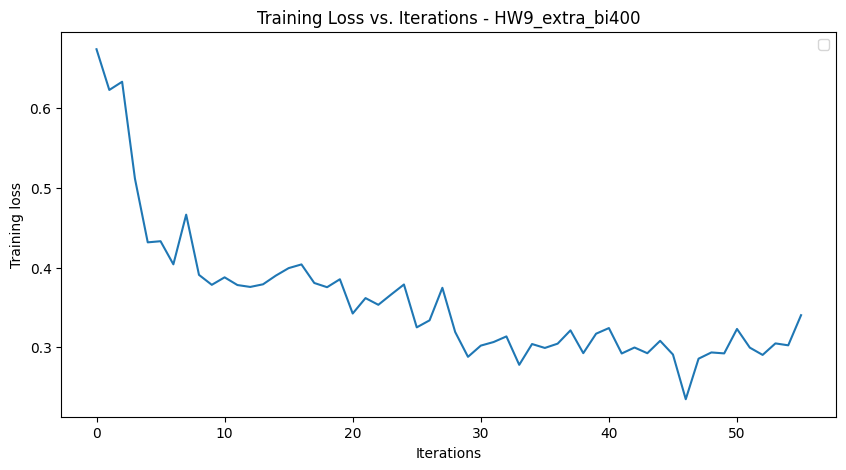

<ipython-input-2-775f6cc263bc>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  review_tensor = torch.FloatTensor(list_of_embeddings)


   [i=500]    predicted_label=1       gt_label=1
   [i=1000]    predicted_label=0       gt_label=0
   [i=1500]    predicted_label=1       gt_label=1
   [i=2000]    predicted_label=0       gt_label=0
   [i=2500]    predicted_label=1       gt_label=1
   [i=3000]    predicted_label=0       gt_label=1
   [i=3500]    predicted_label=1       gt_label=1

Overall classification accuracy: 87.20%


Number of positive reviews tested: 1911


Number of negative reviews tested: 1652


Displaying the confusion matrix:

                      predicted negative    predicted positive

true negative:              89.528%            10.472%
true positive:              14.861%            85.139%


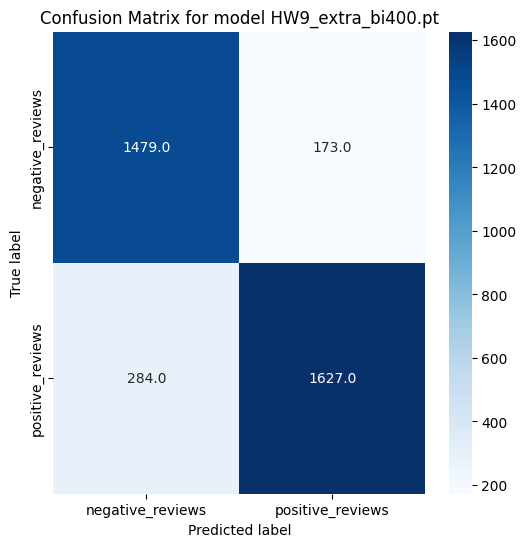

In [ ]:

# Initialize BiGRU with Embeddings
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {device}")

model = BiGRUnetWithEmbeddings(input_size=300, hidden_size=100, output_size=2, num_layers=2)


epochs = 2
display_interval = 500

# Count the number of learnable parameters
number_of_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\nThe number of learnable parameters in the model:", number_of_learnable_params)

# Count the number of layers
num_layers = len(list(model.parameters()))
print("\nThe number of layers in the model:", num_layers)

# training for sentiment_dataset_train_400
net1_losses = run_code_for_training_for_text_classification_with_GRU(device, model, dataloader=train_data_loader,
                                        model_name='HW9_extra_bi400', epochs=epochs, display_interval=display_interval)

# training for sentiment_dataset_train_400
save_path = '/content/drive/My Drive/saved_models/HW9_extra_bi400.pt'
run_code_for_testing_text_classification_with_GRU(device, model, dataloader=test_data_loader,
                             display_interval=display_interval, model_path=save_path, model_name='HW9_extra_bi400.pt')
